![Grounded SAM on SEM Demo](https://github.com/JingliCheng/Grounded-SEM/blob/main/assets/SEM_demo_1.png?raw=true)

## Why apply Grounded-SAM on SEM?

- [Segment Anything](https://github.com/facebookresearch/segment-anything) is a strong segmentation model. But it need prompts (like boxes/points) to generate masks.
- [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) is a strong zero-shot detector which enable to generate high quality boxes and labels with free-form text.
- The combination of the two models enable **to detect and segment new particles in SEM** with text inputs!



## Install

In [1]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"
# !pwd

In [2]:
%%time
# This takes 8 mins

%cd /content

!git clone https://github.com/JingliCheng/Grounded-SEM.git
%cd /content/Grounded-SEM
!pip install -r requirements.txt
%cd /content/Grounded-SEM/GroundingDINO
!pip install .
%cd /content/Grounded-SEM/segment_anything
!pip install .
%cd /content/Grounded-SEM

/content
Cloning into 'Grounded-SEM'...
remote: Enumerating objects: 1677, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 1677 (delta 23), reused 36 (delta 9), pack-reused 1617
Receiving objects: 100% (1677/1677), 111.13 MiB | 13.38 MiB/s, done.
Resolving deltas: 100% (783/783), done.
/content/Grounded-SEM
Processing ./GroundingDINO (from -r requirements.txt (line 13))
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Processing ./segment_anything (from -r requirements.txt (line 40))
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 23.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Using cached 

## Imports

In [3]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

import argparse
import copy

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict
from util.utils import load_model_hf, segment, draw_mask

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

## Load models

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

Using device: cuda


### Grounding DINO model

In [5]:
# def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
#     cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

#     args = SLConfig.fromfile(cache_config_file)
#     args.device = device
#     model = build_model(args)

#     cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
#     checkpoint = torch.load(cache_file, map_location=device)
#     log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
#     print("Model loaded from {} \n => {}".format(cache_file, log))
#     _ = model.eval()
#     return model

In [6]:
# import importlib
# import util.utils

# # Make some changes to your_module_name.py

# # Reload the module
# importlib.reload(util.utils)
# from util.utils import load_model_hf

In [7]:
CKPT_REPO_ID = "ShilongLiu/GroundingDINO"
CKPT_FILENAME = "groundingdino_swinb_cogcoor.pth"
CKPT_CONFIG_FILENAME = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(CKPT_REPO_ID, CKPT_FILENAME, CKPT_CONFIG_FILENAME, DEVICE)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


### SAM

In [8]:
! wget -nc https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

sam_checkpoint = 'sam_vit_h_4b8939.pth'

sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(DEVICE))

--2024-07-27 22:07:54--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.67.181.91, 18.67.181.104, 18.67.181.99, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.67.181.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   247MB/s    in 13s     

2024-07-27 22:08:08 (185 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



## Inference

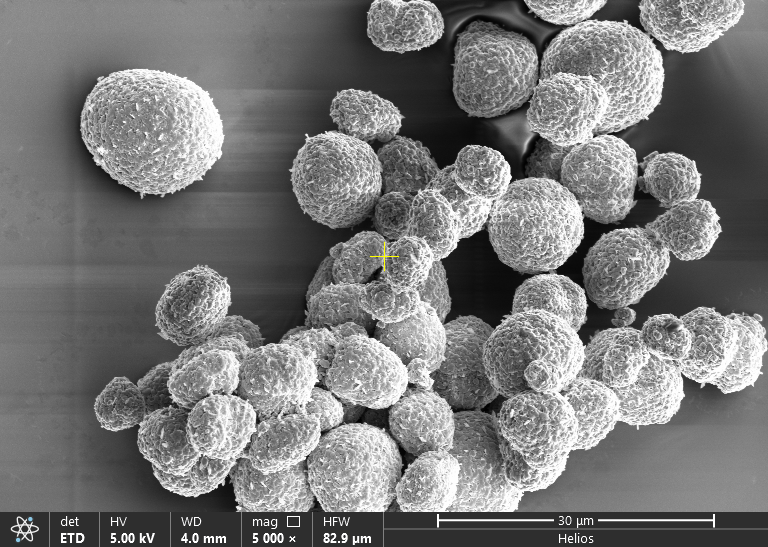

In [9]:
# # Load image
# def download_image(url, image_file_path):
#     r = requests.get(url, timeout=4.0)
#     if r.status_code != requests.codes.ok:
#         assert False, 'Status code error: {}.'.format(r.status_code)

#     with Image.open(BytesIO(r.content)) as im:
#         im.save(image_file_path)
#     print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))


# local_image_path = "assets/inpaint_demo.jpg"
# image_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"

# download_image(image_url, local_image_path)
# image_source, image = load_image(local_image_path)
# Image.fromarray(image_source)

local_image_path = "assets/SEM/SEM_1.png"

image_source, image = load_image(local_image_path)
Image.fromarray(image_source)

## Grounding DINO for detection

In [14]:
# detect object using grounding DINO
def detect(image, text_prompt, model, box_threshold = 0.1, text_threshold = 0.25):
  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB
  return annotated_frame, boxes

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


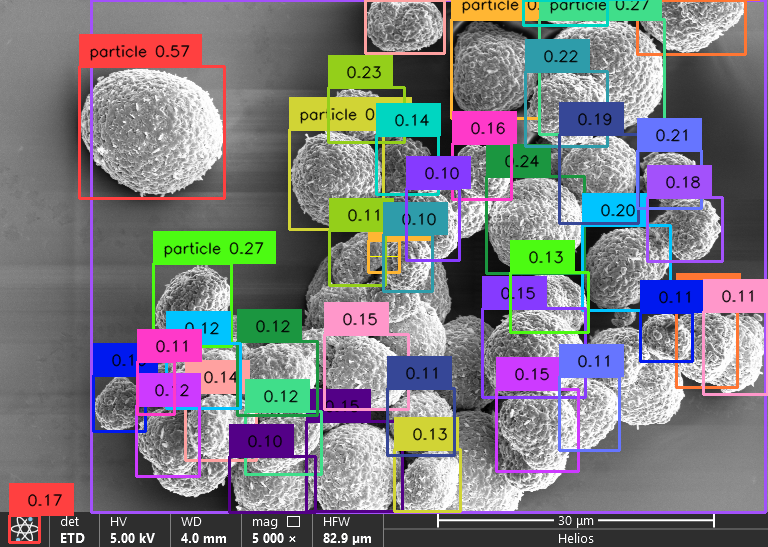

In [15]:
annotated_frame, detected_boxes = detect(image, text_prompt="particle", model=groundingdino_model)
Image.fromarray(annotated_frame)

## SAM for segmentation

In [12]:
# def segment(image, sam_model, boxes, device='cpu'):
#     sam_model.set_image(image)
#     H, W, _ = image.shape
#     boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

#     transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
#     masks, _, _ = sam_model.predict_torch(
#         point_coords = None,
#         point_labels = None,
#         boxes = transformed_boxes,
#         multimask_output = False,
#         )
#     return masks.cpu()


# def draw_mask(mask, image, random_color=True):
#     if random_color:
#         color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
#     else:
#         color = np.array([30/255, 144/255, 255/255, 0.6])
#     h, w = mask.shape[-2:]
#     mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

#     annotated_frame_pil = Image.fromarray(image).convert("RGBA")
#     mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

#     return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

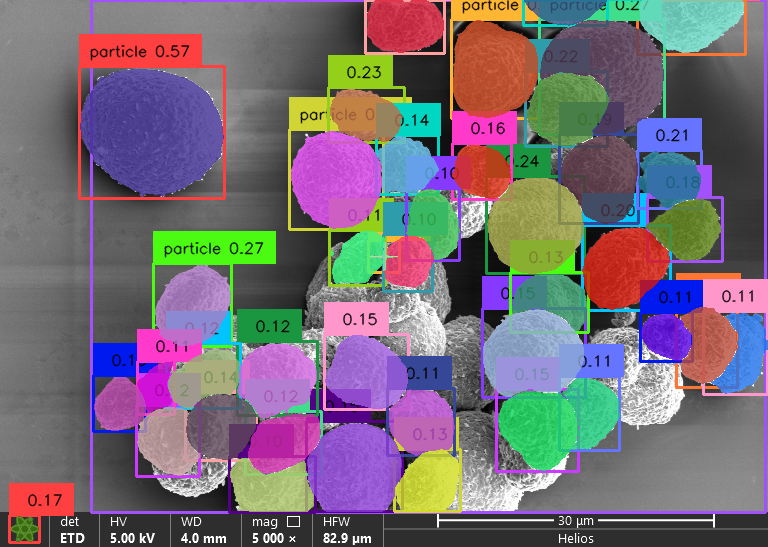

In [13]:
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes, device=DEVICE)
for mask in segmented_frame_masks[1:]:
  annotated_frame = draw_mask(mask[0], annotated_frame)
Image.fromarray(annotated_frame)


## TODO:
1. rename image
2. extract length
3. auto detect the bar size
4. auto resize the image for the best quality
5. auto detect overlap(based on box, not the mask)
6. auto remove outliers(should be done by 5)
7. auto find the statistics.
8. auto search prompt and threshold.